In [1]:
# Import libraries
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.feature_selection as skf
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util
from scipy.spatial import cKDTree
import nibabel as nib
import os
import pickle
from sdv.lite import SingleTablePreset
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import get_column_plot
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import sklearn.neighbors as skn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [3]:
# Maybe y should also be scaled? 
# Perhaps a transform would be more effective, or scaling implemented with consistent cross-validation
# Different scaling methods? 
#     This seems most important for noise-sensitive models like LARS. All other use StandardScaler()
# Transformers?
# Model-specific scaling methods?
#     Yes, see above
# Common cross-validation function ✓
#     Use built-in functions wherever possible and `utils.gridsearch_pickparams()` elsewhere
# Quantile loss
# RANSAC
# Data augmentation? (Mixup)
# Data generation? (SMOGN)
# Combine CHH dataset ✓
# Implement CV and test ✓
# Print selected features ✓
# Make magnitude templates
# Sample weights ✓
# Look at segmentations by error ✓ (Appears to have most difference in red nucleus, which includes surrounding (white?) matter for underperforming cases)
# Extract features from current (1:6) eroded ROIs
# Extract features from all ROIs
# Plot segmentation variance against error for each case across all ROIs ✓
# Why does excluding the subthalamic nucleus increase the correlation (r=0.5 -> r=0.6)?
# Best performance with all ROIs: cvn=6, k=1800
# Best performance with ROIs 0:4, excluding STN: cvn=6, k=1800
# Should the pre-operative UPDRS be appended once or to each ROI? ✓
# Plot histogram of features for successful and unsuccessful predictions

In [4]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528_wldd.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','pre op levadopa equivalent dose (mg)','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off,ledd = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo',
                                                          'pre op levadopa equivalent dose (mg)')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,all_rois)
R = np.random.randint(low=0,high=1e6,size=(K_all.shape))
K_all = np.char.add(K_all,R.astype(str))
ids = np.asarray(ID_all).astype(int)

# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
# Omit full reduction data
# c_cases_idx[np.where(subs==61)] = 0
# c_cases_idx[np.where(subs==69)] = 0
X_all_c = X_all[c_cases_idx,0:4,:]
K_all_c = K_all[c_cases_idx,0:4,:]
R_all_c = R_all[c_cases_idx,0:4,:]
print(R_all_c)
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
subsc = subs[s_cases_idx]
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]
ledd = ledd[s_cases_idx]
per_change = post_imp
# Reshape keys and ROIs
if all_rois == True:
    K_all_cu = np.empty((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+2),dtype=object)
    K_all_cu[:,:,:-1] = K_all_c
    K_all_cu[:,:,-1] = 'pre_updrs'
    K_all_c[:,:,-1] = 'ledd'
    K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))[0]
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))
else:
    K = K_all_c.reshape((K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2]))[0]
    K = np.append(K,['pre_updrs'],0)
    K = np.append(K,['ledd'],0)
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))



       Unnamed: 0                PRE-OP           Unnamed: 2  \
0      CORNELL ID  Apathy Off (pre-dbs)  Apathy ON (pre-dbs)   
1              67                    na                   13   
2   only Ct data                     na                   na   
3              74                    na                   na   
4              84                    na                   22   
..            ...                   ...                  ...   
87             52                   NaN                  NaN   
88             53                   NaN                  NaN   
89             54                   NaN                  NaN   
90             55                   NaN                  NaN   
91             56                   NaN                  NaN   

             Unnamed: 3          Unnamed: 4    Unnamed: 5  \
0   OFF (pre-dbs updrs)  ON (pre-dbs updrs)  mri (pre-op)   
1                    60                  41      3/9/2020   
2                    43                  12     

In [5]:
scoring = 'r2'
results_bls = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_gls = np.zeros_like(per_change)
gerror = np.zeros_like(per_change)
r = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
err_var = np.zeros_like(per_change)
alphas = np.logspace(-4,4,100)
Ks = []
Kstg = []
w = []
wg = []
pcases = []
pscores = []
s = []

In [35]:

Js = []
regen = 0
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" #
err_var = np.zeros_like(per_change)
r = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
kappa = []
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    X_test = np.append(X_test,pre_updrs_off[test_index])
    X_test = np.append(X_test,ledd[test_index])
    X_test = np.insert(X_test,0,subsc[test_index])
    y_train = per_change[train_index]
    y_test = per_change[test_index]


    Kt = K
    Kt = np.append(Kt,['per_change'])
    Kt = np.insert(Kt,0,['id'])
    T = X_train.reshape(X_train.shape[0],-1)
    T = np.append(T,pre_updrs_off[train_index].reshape(-1,1),axis=1)
    T = np.append(T,ledd[train_index].reshape(-1,1),axis=1)
    T = np.append(T,y_train.reshape(-1,1),axis=1)
    T = np.insert(T,0,subsc[train_index],axis=1)
  
    if regen == 1:
        T = pd.DataFrame(data=T,columns=Kt)
        T.astype({'id': 'int32'}).dtypes
        metadata = SingleTableMetadata()
        metadata.detect_from_dataframe(T)
        metadata.update_column(
            column_name='id',
            sdtype='id')
        metadata.set_primary_key(
            column_name='id')
        metadata.validate()
        synthesizer = SingleTablePreset(metadata, name='FAST_ML')
        synthesizer.fit(data=T)
        Ts = synthesizer.sample(100)
        Xs = Ts.to_numpy()        
        np.save('/home/ali/RadDBS-QSM/data/sdv/Xs_'+str(subsc[j])+'.npy',Xs)

    else:
        Xs = np.load('/home/ali/RadDBS-QSM/data/sdv/Xs_'+str(subsc[j])+'.npy')
    
    y_train = np.append(y_train,Xs[:,-1])
    X_train = np.append(T[:,:-1],Xs[:,:-1],axis=0)

    # Cross validation
    scaler = skp.StandardScaler()
    X0_ss0 = scaler.fit_transform(X_train)
    X_test_ss0 = scaler.transform(X_test.reshape(1, -1))
    cvn = len(X0_ss0-1)
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
    # Feature selection
        #warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sel = skf.SelectKBest(skf.r_regression,k=15)
        X0_ss = sel.fit_transform(X0_ss0,y_train)
        X_test_ss = sel.transform(X_test_ss0)

        est = skn.KNeighborsRegressor(n_neighbors=2, weights='distance', metric='l2')
        knn = est.fit(X0_ss, y_train)
        results_ls[j] = knn.predict(X_test_ss)
    print('Lasso predicts',str(np.round(results_ls[j],5)),
            'for case',str(subsc[j]),'with',str(np.round(per_change[j],2)))
            

  


Lasso predicts 0.62714 for case 67.0 with 0.48
Lasso predicts 0.63627 for case 75.0 with 0.97
Lasso predicts 0.59129 for case 68.0 with 0.75
Lasso predicts 0.77364 for case 79.0 with 0.66
Lasso predicts 0.91034 for case 59.0 with 0.74
Lasso predicts 0.41351 for case 85.0 with 0.15
Lasso predicts 0.5574 for case 63.0 with 0.85
Lasso predicts 0.34311 for case 66.0 with 0.53
Lasso predicts 0.43775 for case 86.0 with 0.5
Lasso predicts 0.71098 for case 69.0 with 0.49
Lasso predicts 0.25663 for case 72.0 with 0.26
Lasso predicts 0.6428 for case 80.0 with 0.52
Lasso predicts 0.3216 for case 81.0 with 0.19
Lasso predicts 0.48167 for case 77.0 with 0.56
Lasso predicts 0.33227 for case 64.0 with 0.66
Lasso predicts 0.29982 for case 83.0 with 0.84
Lasso predicts 0.36264 for case 62.0 with 0.47
Lasso predicts 0.39689 for case 87.0 with 0.09
Lasso predicts 0.84166 for case 58.0 with 0.52
Lasso predicts 0.46322 for case 89.0 with 0.36
Lasso predicts 0.3531 for case 78.0 with 0.82
Lasso predicts 0.3

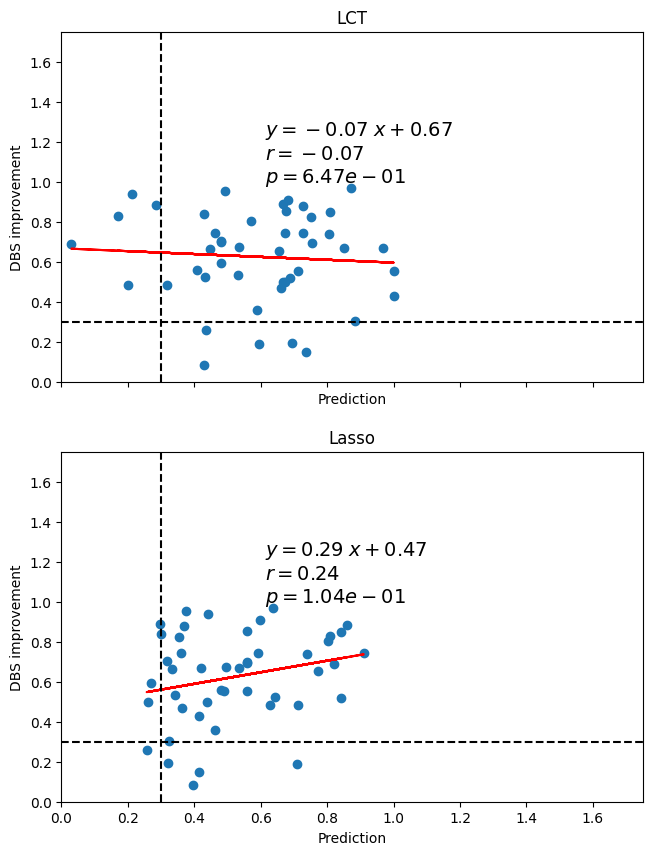

In [36]:
results_ls[results_ls>1] = 1
util.eval_prediction(np.vstack((pre_imp,
                               results_ls,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,1.75])
plt.xlim([0,1.75])
plt.style.use('default')